In [ ]:
import datetime
import json
import math
import os
import random
import sys
import time
from functools import partial
from pathlib import Path
from typing import Any, Callable, Dict, List, Mapping, Optional, Tuple, Union

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import polars.selectors as cs
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from polars import DataFrame, Series
from polars._typing import ColumnNameOrSelector
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import polars_ml as pml
from polars_ml.model_selection import KFold, train_test_split


/home/hoge/polars-ml/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_train_data = pl.read_csv("../../data/train.csv")
raw_test_data = pl.read_csv("../../data/test.csv")
submit_data = pl.read_csv("../../data/sample_submission.csv")

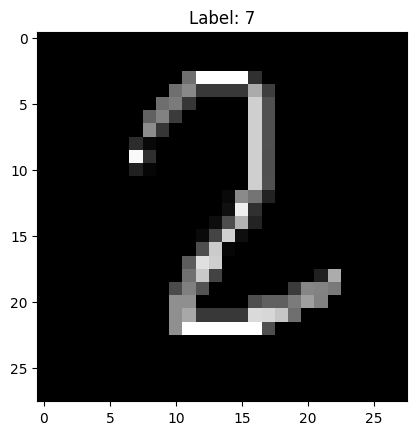

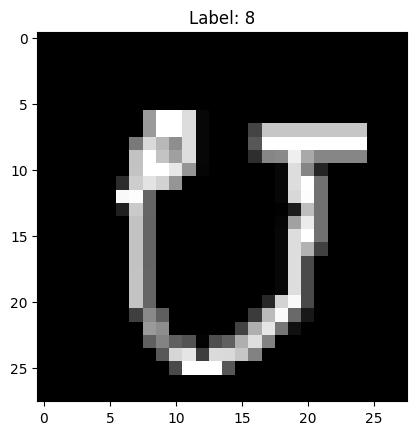

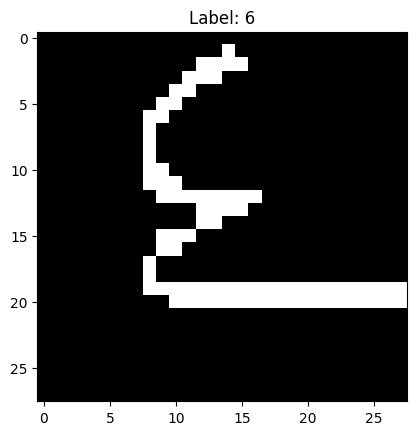

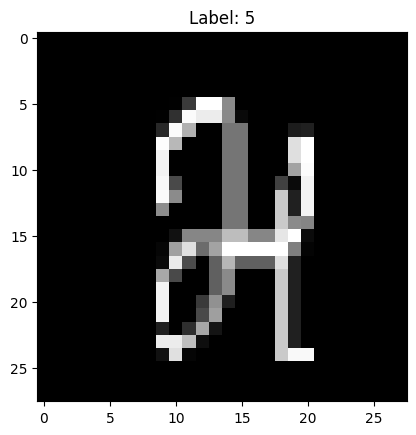

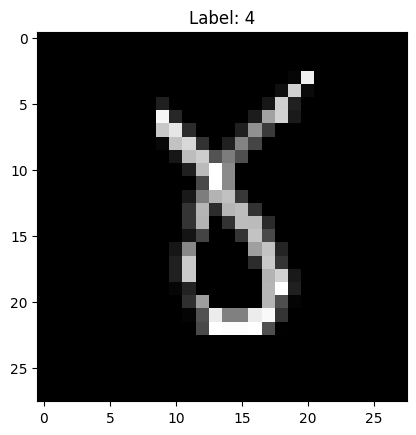

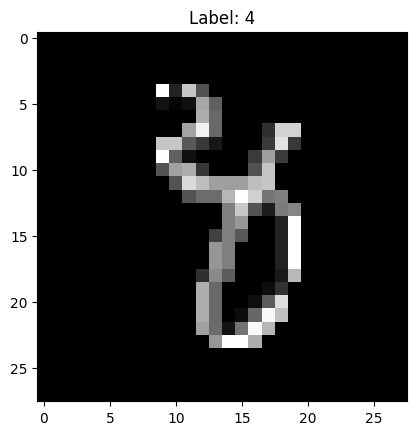

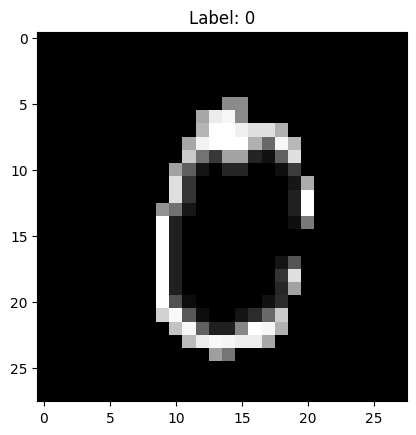

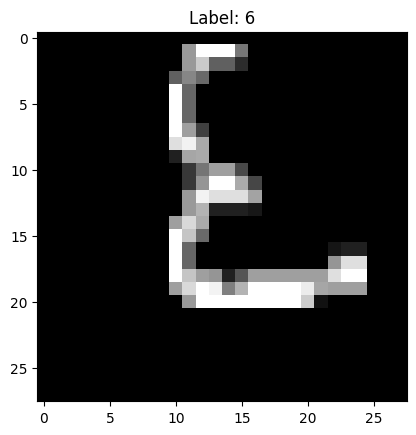

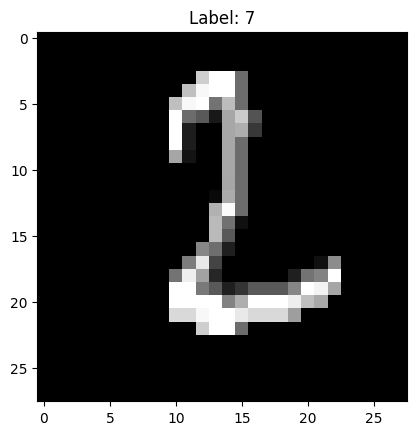

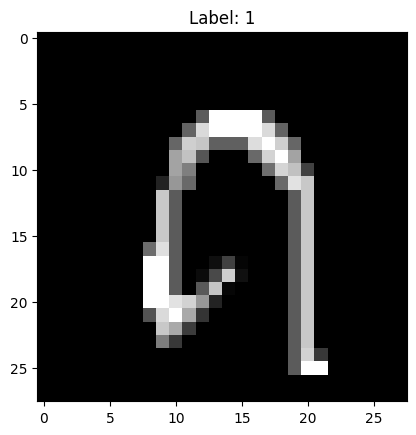

In [10]:
train_label = raw_train_data["label"]
train_pixels = raw_train_data.select(pl.exclude("label"))
train_images = train_pixels.to_numpy().reshape(-1, 28, 28).astype(np.uint8)

random_index: list[int] = np.random.randint(0, len(train_images), 10).tolist()
for i in random_index:
    plt.imshow(train_images[i], cmap="gray")
    plt.title(f"Label: {train_label[i]}")
    plt.show()


In [ ]:
def make_input(data: DataFrame) -> torch.Tensor:
    images = data.select(cs.starts_with("pixel")).to_torch()
    images = images.reshape(-1, 1, 28, 28).float() / 255.0
    return images


class KannadaMNISTDataModule(L.LightningDataModule):
    def __init__(
        self,
        data: DataFrame,
        validation_data: DataFrame | Mapping[str, DataFrame] | None = None,
        *,
        batch_size: int = 1024,
        num_workers: int = 0,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers

        assert isinstance(validation_data, DataFrame)

        train_label = data["label"].to_numpy()
        valid_label = validation_data["label"].to_numpy()
        self.train_dataset = TensorDataset(
            make_input(data), torch.from_numpy(train_label).long()
        )
        self.valid_dataset = TensorDataset(
            make_input(validation_data), torch.from_numpy(valid_label).long()
        )

    def train_dataloader(self) -> DataLoader[tuple[torch.Tensor, ...]]:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader[tuple[torch.Tensor, ...]]:
        return DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )


class KannadaMNISTEfficientNet(L.LightningModule):
    def __init__(self, num_classes: int = 10, learning_rate: float = 1e-3) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.model = timm.create_model(
            "efficientnet_b0", pretrained=True, in_chans=1, num_classes=num_classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(
        self, batch: tuple[torch.Tensor, ...], batch_idx: int
    ) -> torch.Tensor:
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(
        self, batch: tuple[torch.Tensor, ...], batch_idx: int
    ) -> torch.Tensor:
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("val_loss", loss)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    filename="mnist-efficientnet-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)
logger = TensorBoardLogger("tb_logs", name="mnist_efficientnet")
pp = pml.nn.PytorchLightning(
    make_input,
    KannadaMNISTDataModule,
    KannadaMNISTEfficientNet(),
    L.Trainer(
        max_epochs=10,
        callbacks=[checkpoint_callback],
        logger=logger,
        accelerator="auto",
    ),
)

train_idx, valid_idx = train_test_split(
    raw_train_data, 0.1, stratify="label", shuffle=True, seed=42
)
train_data = raw_train_data.select(pl.all().gather(train_idx))
valid_data = raw_train_data.select(pl.all().gather(valid_idx))

pp.fit(train_data, valid_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | EfficientNet | 4.0 M  | train
-----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.079    Total estimated model params size (MB)
321       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/hoge/polars-ml/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/hoge/polars-ml/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/hoge/polars-ml/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s, v_num=1, train_acc=0.997, val_acc=0.988]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s, v_num=1, train_acc=0.997, val_acc=0.988]
